
## Motivation: 

PyTorch has support for acceleration using the Apple M1 chip
Want to explore if the FBP algorithm can be implemented using PyTorch and hence
be accelerated on the Mac.

## Sources
Acceleration with PyTorch on the Mac, various blog posts and official release
- https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c
- https://sebastianraschka.com/blog/2022/pytorch-m1-gpu.html
- https://pytorch.org/blog/introducing-accelerated-pytorch-training-on-mac/

FBP algorithm source, from scikit-image package
- https://github.com/scikit-image/scikit-image/blob/v0.19.2/skimage/transform/radon_transform.py#L176-L304



In [1]:
import torch
from torch.fft import fft, fftfreq, fftshift, ifft
from torch.nn.functional import interpolate, pad
from skimage._shared.utils import convert_to_float
from scipy.interpolate import interp1d
from functools import partial  # Some form of wrapper function

from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)


def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.
    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.
    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.
    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    """
    n = torch.cat((torch.arange(1, size / 2 + 1, 2, dtype=int),
                           torch.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = torch.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (torch.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * torch.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = torch.pi * fftfreq(size)[1:]
        fourier_filter[1:] *= torch.sin(omega) / omega
    elif filter_name == "cosine":
        freq = torch.linspace(0, torch.pi, size, endpoint=False)
        cosine_filter = fftshift(torch.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftshift(torch.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftshift(torch.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, None]


def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True,
           preserve_range=True):
    """Inverse radon transform.
    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.
    Parameters
    ----------
    radon_image : array
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different
        angle. The tomography rotation axis should lie at the pixel
        index ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int, optional
        Number of rows and columns in the reconstruction.
    filter_name : str, optional
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.
    preserve_range : bool, optional
        Whether to keep the original range of values. Otherwise, the input
        image is converted according to the conventions of `img_as_float`.
        Also see https://scikit-image.org/docs/dev/user_guide/data_types.html
    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.
    .. versionchanged:: 0.19
        In ``iradon``, ``filter`` argument is deprecated in favor of
        ``filter_name``.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
           the Discrete Radon Transform With Some Applications", Proceedings of
           the Fourth IEEE Region 10 International Conference, TENCON '89, 1989
    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.
    """
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = torch.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    # radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    ##### Actual FBP Algorithm #################################################
    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(
        64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)
    img = torch.tensor(img)
    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = torch.real(ifft(projection, axis=0)[:img_shape, :])

    # TODO expect this to a bit weird because of interpolation
    # Reconstruct image by interpolation
    reconstructed = torch.zeros((output_size, output_size),
                                dtype=dtype)
    radius = output_size // 2
    xpr, ypr = torch.mgrid[:output_size, :output_size] - radius
    x = torch.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, torch.deg2rad(theta)):
        t = ypr * torch.cos(angle) - xpr * torch.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interpolate(x, col, kind=interpolation,
                                      bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.

    return reconstructed * torch.pi / (2 * angles_count)

iradon(sinogram[105], theta)

NameError: name 'sinogram' is not defined

In [3]:
print('hi')
# Makes sure the hardware is available
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
import numpy as np

PATH_TO_IMAGE = '../data_store/aligned.tif'
im = io.imread(PATH_TO_IMAGE)
print(type(im))
# Change dtype as PyTorch does not support uint16
im = np.ndarray.astype(im, 'float32')
im = torch.tensor(im, dtype=torch.float32)

hi
True
True
<class 'numpy.ndarray'>


In [4]:
theta = np.linspace(0, 360, im.shape[0], endpoint=False)
theta = torch.tensor(theta, requires_grad=False)

In [5]:
sinogram = torch.moveaxis(im, 0, -1)

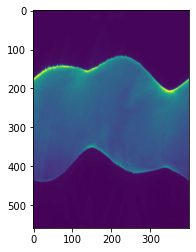

In [6]:
plt.imshow(sinogram[105])

In [7]:
sinogram[15].shape

torch.Size([558, 400])

In [8]:
# if radon_image.ndim != 2:
    # raise ValueError('The input image must be 2-D')

# if theta is None:
    # theta = torch.linspace(0, 180, radon_image.shape[1], endpoint=False)

# angles_count = len(theta)
# if angles_count != radon_image.shape[1]:
    # raise ValueError("The given ``theta`` does not match the number of "
                        # "projections in ``radon_image``.")

# interpolation_types = ('linear', 'nearest', 'cubic')
# if interpolation not in interpolation_types:
    # raise ValueError("Unknown interpolation: %s" % interpolation)

# filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
# if filter_name not in filter_types:
    # raise ValueError("Unknown filter: %s" % filter_name)

# radon_image = convert_to_float(radon_image, preserve_range)
radon_image = sinogram[15]
dtype = radon_image.dtype
filter_name = 'ramp'

img_shape = radon_image.shape[0]
output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

# if output_size is None:
#     # If output size not specified, estimate from input radon image
#     if circle:
#         output_size = img_shape
#     else:
#         output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

# if circle:
#     radon_image = _sinogram_circle_to_square(radon_image)
#     img_shape = radon_image.shape[0]

# ##### Actual FBP Algorithm #################################################
# Resize image to next power of two (but no less than 64) for
# Fourier analysis; speeds up Fourier and lessens artifacts
projection_size_padded = max(
    64, int(2 ** np.ceil(np.log2(2 * img_shape))))
# Change to tuple of ints from tuple of tuples, also change order due to PyTorch notation
pad_width = (0, 0, 0, projection_size_padded - img_shape)
img = pad(radon_image, pad_width, mode='constant', value=0)

# Apply filter in Fourier domain
fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
projection = fft(img, axis=0) * fourier_filter
radon_filtered = torch.real(ifft(projection, axis=0)[:img_shape, :])

In [11]:
radon_image.shape

torch.Size([558, 400])

In [146]:
# Reconstruct image by interpolation
interpolation = 'nearest'
reconstructed = torch.zeros((output_size, output_size),
                            dtype=dtype)
radius = output_size // 2

radius_range = torch.arange(0,output_size) - radius

xpr, ypr = torch.meshgrid(radius_range, radius_range, indexing='ij') 
x = torch.arange(img_shape) - img_shape // 2

# Backproject each line in the sinogram, by rotating it and adding it to the sum
# TODO (not done in PyTorch)
for col, angle in zip(radon_filtered.T, torch.deg2rad(theta)):
    t = ypr * torch.cos(angle) - xpr * torch.sin(angle)
#     if interpolation == 'linear':
#         interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
#     else:
#         interpolant = interpolate(x, col, kind=interpolation,
#                                     bounds_error=False, fill_value=0)
    interpolant = interpolate(x, col, mode=interpolation)
    reconstructed += interpolant(t)

# if circle:
#     out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
#     reconstructed[out_reconstruction_circle] = 0.

# return reconstructed * torch.pi / (2 * angles_count)

NotImplementedError: Input Error: Only 3D, 4D and 5D input Tensors supported (got 1D) for the modes: nearest | linear | bilinear | bicubic | trilinear | area | nearest-exact (got nearest)

In [149]:
radon_filtered.T[0].shape

torch.Size([558])

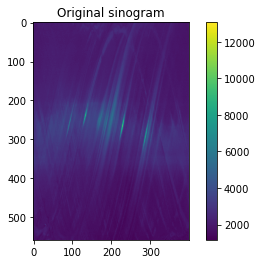

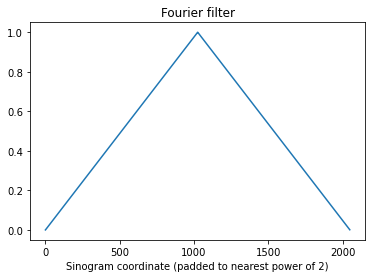

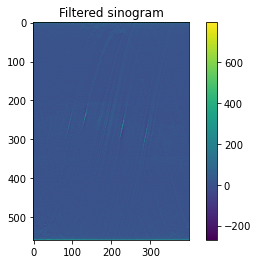

In [103]:
plt.title('Original sinogram')
plt.imshow(radon_image)
plt.colorbar()
plt.show()

plt.title('Fourier filter')
plt.plot(fourier_filter)
plt.xlabel('Sinogram coordinate (padded to nearest power of 2)')
plt.show()

plt.title('Filtered sinogram')

plt.imshow(radon_filtered)
plt.colorbar()
plt.show()